# Import

In [ ]:
import requests
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d    
import seaborn as sns
from plotnine import *

from scipy.linalg import svd
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

np.random.seed(0)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, RepeatedKFold
from sklearn.metrics import r2_score, f1_score, mean_squared_error

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor #dummy regressor bases prediction on the mean of target variable
from sklearn.neural_network import MLPRegressor #Neural network - multilayer perceptron

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import sklearn.tree
import sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn import model_selection

from IPython.display import clear_output
from IPython.display import display


#from toolbox_02450 import *
# requires data from exercise 1.5.1
#from ex5_1_5 import *

"""

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Introduction_to_machine_learning/02450Toolbox_Python/Tools/toolbox_02450/')
"""

"\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\nimport sys\nsys.path.append('/content/drive/MyDrive/Introduction_to_machine_learning/02450Toolbox_Python/Tools/toolbox_02450/')\n"

# Load preprocess

In [ ]:
# Load the 'Heart failure clinical records dataset' csv data using the Pandas library
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"
try:
    df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
except FileNotFoundError:
    r = requests.get(URL, allow_redirects=True)
    open('heart_failure_clinical_records_dataset.csv', 'wb').write(r.content)
    df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Pandas returns a dataframe, (df) which could be used for handling the data.
# Convert the dataframe to numpy arrays
raw_data = df.values

In [ ]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [ ]:
len(df.columns)

13

In [ ]:
X = df[[column for column in df.columns if column != 'serum_creatinine']].values
y = df['serum_creatinine'].values

## Regression, part a) 
###Linear Regression

In [ ]:
def standarize(X_train, X_test): #standarizes dataset based on mean and stdev
  mu = np.mean(X_train, 0)
  sigma = np.std(X_train, 0)
  X_train = (X_train - mu) / sigma
  X_test = (X_test - mu) / sigma
  return mu, sigma, X_train, X_test

def standarize_simple(X): #standarizes dataset based on mean and stdev
  mu = np.mean(X_train, 0)
  sigma = np.std(X_train, 0)
  X = (X - mu) / sigma
  return X

def get_regularization_param(start=1e-05,steps=11,magnitude=10): #Generates the list of gerneralization parameters with increasing order of magnitude
  reg_param  = start
  regularization_strength_lst = []
  for r in range(0,steps):
    regularization_strength_lst.append(reg_param)
    reg_param = reg_param * magnitude
  return regularization_strength_lst

def get_regularization_param_2(start=1e-05,steps=11,magnitude=10): #Generates the list of gerneralization parameters with increasing order of magnitude
  reg_param  = start
  regularization_strength_lst = []
  for r in range(0,steps):
    regularization_strength_lst.append(reg_param)
    reg_param = reg_param + magnitude
  return regularization_strength_lst

def plot_errors(lambdas,test_errors, title,train_errors=''):
    plt.figure(figsize=(16, 9))
    if train_errors != '':
      plt.plot(lambdas, train_errors, label="Training error", color='blue', marker='o')
    plt.plot(lambdas, test_errors, label="Generalization error", color='orange', marker='o')
    plt.xlabel("$\\lambda$", fontsize=14)
    plt.ylabel("MSE", fontsize=14)
    plt.title(title, fontsize=20)
    plt.legend(fontsize=14)
    plt.show()

# Establishing the most optimal regularization parameter

Error expressed as weighted average ploted against lambda parameter

Reg params list [0.001, 0.002, 0.003] ... [0.09700000000000007, 0.09800000000000007, 0.09900000000000007]


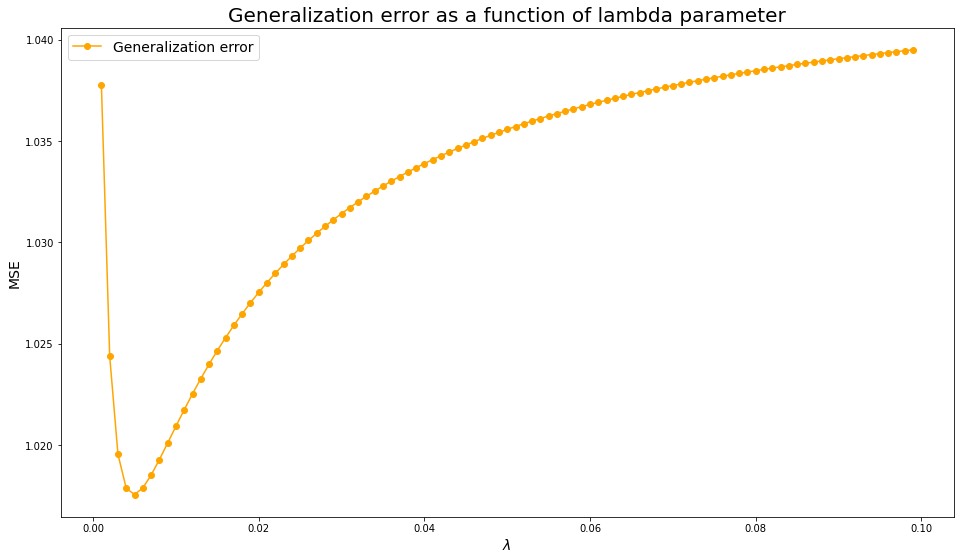

Best regularization parameter: 0.005
Lowest minimum squared error: 1.018


In [ ]:
reg_params_list = get_regularization_param_2(start=0,steps=11,magnitude=0.001)[1:]
print(f'Reg params list {reg_params_list[:3]} ... {reg_params_list[-3:]}')
K = 10 # folds num
fold_test_errors = []
fold_train_errors = []

kf = model_selection.KFold(n_splits=K)

for reg_param in reg_params_list:
  test_errors = []
  train_errors = []
  mdl = Ridge(alpha = 1/reg_param)
  for train_index, test_index in kf.split(X):

      X_train, y_train = X[train_index,:], y[train_index]
      X_test, y_test = X[test_index, :], y[test_index]

      mu, sigma, X_train, X_test = standarize(X_train, X_test)
  
      mdl.fit(X_train,y_train)
      y_test_est = mdl.predict(X_test)
      y_train_est = mdl.predict(X_train)

      test_errors.append((len(y[test_index]) / len(y)) * mean_squared_error(y_test, y_test_est)) #  weight (fraction of observation on which tested) * error 
      #train_errors.append((len(y[train_index]) / len(y)) * mean_squared_error(y_train, y_train_est))

  fold_test_errors.append(sum(test_errors))
  #fold_train_errors.append(sum(train_errors))

plot_errors(reg_params_list, fold_test_errors, 'Generalization error as a function of lambda parameter')

best_lambda = [reg_params_list[i] for i in range(len(fold_test_errors)) if fold_test_errors[i] == min(fold_test_errors)][0]
best_mae = min(fold_test_errors)

print(f'Best regularization parameter: {round(best_lambda,3)}\nLowest minimum squared error: {round(best_mae,3)}')

# Retraining with newly selected lambda value

In [ ]:
kf = model_selection.KFold(n_splits=K)

test_errors = []
train_errors = []
mdl = Ridge(alpha = 1/best_lambda)
for train_index, test_index in kf.split(X):

    X_train, y_train = X[train_index,:], y[train_index]
    X_test, y_test = X[test_index, :], y[test_index]

    mu, sigma, X_train, X_test = standarize(X_train, X_test)

    mdl.fit(X_train,y_train)
    y_test_est = mdl.predict(X_test)
    y_train_est = mdl.predict(X_train)

    test_errors.append(mean_squared_error(y_test, y_test_est))
    train_errors.append(mean_squared_error(y_train, y_train_est))

print(f'Lambda: {round(best_lambda,3)}\nTraining error {round(np.mean(train_errors),3)}\nTesting error: {round(np.mean(test_errors),3)}')

Lambda: 0.005
Training error 0.951
Testing error: 1.015


## Features evaluation

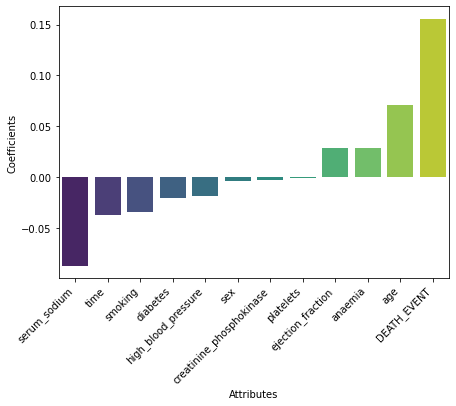

In [ ]:
names = [column for column in df.columns if column != 'serum_creatinine']
coef_df = pd.DataFrame({'Attributes' : names, 'Coefficients' : mdl.coef_}).sort_values('Coefficients')
plt.figure(figsize=(7,5))
sns.barplot(x = coef_df.Attributes, y = coef_df.Coefficients, data = coef_df,palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.show()

# Two fold cross validation

In [ ]:
models = [MLPRegressor, Ridge, DummyRegressor]
#models = [Ridge, DummyRegressor]

In [ ]:
def two_kfold(X,reg_params_list, K = 10, hl_step = 1):
   # folds num
  K1 = model_selection.KFold(n_splits=K)
  K2 = model_selection.KFold(n_splits=K)

  test_error_lst = []

  X = standarize_simple(X)
  outer_test_loop = pd.DataFrame()
  
  #Outer loop model testing using found best params
  for i, (par_index, test_index) in enumerate(K1.split(X)):
    X_par, y_par = X[par_index, :], y[par_index]
    X_test, y_test = X[test_index, :], y[test_index]
    
    # Inner loop Finding optimal lambda and hidden layers number
    all_params_errors = []
    for k_no, (train_index, val_index) in enumerate(K2.split(X_par)):
      X_train, y_train = X[train_index, :], y[train_index]
      X_val, y_val = X[val_index, :], y[val_index]
      hidden_layers = 1
      for reg_param in reg_params_list: #number of hidden layers tested will equal to the number of reg_param
        one_param_errors = []
        for model in models:
          if model.__name__ == 'Ridge':
            mdl = model(alpha=1/reg_param)
          elif model.__name__ == 'MLPRegressor':
            mdl = model(hidden_layer_sizes = (hidden_layers,),max_iter=10000, solver='lbfgs')
          else:
            mdl = model()
          if model.__name__ == 'DummyRegressor':
            mdl.fit(y_train, y_train)
          else:
            mdl.fit(X_train,y_train)
          y_val_est = mdl.predict(X_val)
          e_val = (len(val_index) / len(par_index)) * mean_squared_error(y_val, y_val_est)
          one_param_errors.append(e_val)
        all_params_errors.append(one_param_errors + [i+1, k_no+1,hidden_layers,reg_param])
        hidden_layers += hl_step
        #print(i+1, k_no+1,hidden_layers,round(reg_param,6),round(one_param_errors[0],3),round(one_param_errors[1],3),round(one_param_errors[2],3))
        #clear_output(wait=True)
    
    #Selecting optimal lambda and optimal hidden layers number
    all_params_errors = pd.DataFrame(all_params_errors,columns = [mdl.__name__ for mdl in models] + ['outer_fold','inner_fold', 'hl', 'lambda'])
    
    #Generalization error estimate from validation and lambda choice
    best_lambda = all_params_errors.groupby('lambda').Ridge.mean().sort_values().index[0]
    best_hl = all_params_errors.groupby('hl').MLPRegressor.mean().sort_values().index[0]    
    optimal_params = pd.DataFrame({'hl' : [best_hl], 'lambda' : [best_lambda]})
    
    ########## Training and testing using best parameters
    test_errors = []

    for model in models:
      if model.__name__ == 'Ridge':
        mdl = model(alpha=1/optimal_params['lambda'].values[0])
      elif model.__name__ == 'MLPRegressor':
        mdl = model(hidden_layer_sizes = (optimal_params.hl.values[0],), max_iter=10000, solver='lbfgs')
      else:
        mdl = model()

      if model.__name__ == 'DummyRegressor':
        mdl.fit(y_par, y_par)
      else:
        mdl.fit(X_par, y_par)
      y_test_est = mdl.predict(X_test)
      e_test = (len(y_test) / len(X)) * mean_squared_error(y_test, y_test_est)
      test_errors.append(e_test)
    
    data = test_errors + [i+1] + [optimal_params['lambda'].values[0], optimal_params.hl.values[0]]
    cols = [mdl.__name__ for mdl in models] + ['outer_fold','lambda','hl']
    outer_test_loop = pd.concat([outer_test_loop.reset_index(drop=True), pd.DataFrame(data=[data], columns=cols).reset_index(drop=True)])
    print('\t\t', data)
  return all_params_errors,outer_test_loop.reset_index(drop=True)

#Hidden Layers number as the funciton of Validation error in the interval of 1 layers increase per training loop

fold hl lambda MLPRegressor Ridge DummyRegressor
1 1 0.001 0.28 0.255 0.264
1 4 0.002 0.32 0.251 0.264
1 7 0.003 0.239 0.249 0.264
1 10 0.004 0.276 0.248 0.264
1 13 0.005 0.235 0.248 0.264
1 16 0.006 0.299 0.247 0.264
1 19 0.007 0.309 0.247 0.264
1 22 0.008 0.276 0.247 0.264
1 25 0.009 0.295 0.247 0.264
1 28 0.01 0.282 0.247 0.264
1 31 0.011 0.292 0.247 0.264
1 34 0.012 0.285 0.247 0.264
1 37 0.013 0.327 0.247 0.264
1 40 0.014 0.305 0.247 0.264
1 43 0.015 0.299 0.247 0.264
1 46 0.016 0.318 0.247 0.264
1 49 0.017 0.344 0.247 0.264
1 52 0.018 0.259 0.247 0.264
1 55 0.019 0.275 0.247 0.264
1 58 0.02 0.317 0.247 0.264


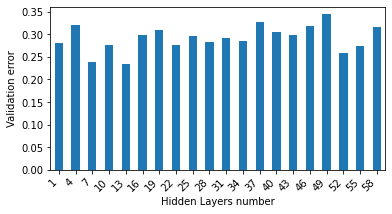

In [ ]:
all_params_errors = two_kfold(X=X,reg_params_list=reg_params_list, K=20,hl_step=3)
all_params_errors[['MLPRegressor']].plot.bar(figsize=(6,3),legend=None)
plt.ylabel('Validation error')
plt.xlabel('Hidden Layers number')
plt.xticks(ticks = np.arange(0,20), labels = all_params_errors.hl.values, rotation = 45, ha='right')
plt.show()

fold hl lambda MLPRegressor Ridge DummyRegressor
1 1 0.001 0.355 0.278 0.287
1 11 0.002 0.329 0.275 0.287
1 21 0.003 0.442 0.275 0.287
1 31 0.004 0.416 0.275 0.287
1 41 0.005 0.605 0.275 0.287
1 51 0.006 0.448 0.276 0.287
1 61 0.007 0.353 0.277 0.287
1 71 0.008 0.462 0.277 0.287
1 81 0.009 0.417 0.278 0.287
1 91 0.01 0.51 0.278 0.287
1 101 0.011 0.438 0.279 0.287
1 111 0.012 0.432 0.279 0.287
1 121 0.013 0.447 0.28 0.287
1 131 0.014 0.496 0.28 0.287
1 141 0.015 0.532 0.28 0.287
1 151 0.016 0.507 0.281 0.287
1 161 0.017 0.452 0.281 0.287
1 171 0.018 0.491 0.281 0.287
1 181 0.019 0.448 0.282 0.287
1 191 0.02 0.502 0.282 0.287


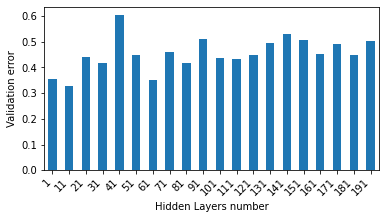

In [ ]:
all_params_errors = two_kfold(X=X,reg_params_list=reg_params_list, K=10, hl_step=10)
all_params_errors[['MLPRegressor']].plot.bar(figsize=(6,3),legend=None)
plt.ylabel('Validation error')
plt.xlabel('Hidden Layers number')
plt.xticks(ticks = np.arange(0,20), labels = all_params_errors.hl.values, rotation = 45, ha='right')
plt.show()

#Results of optimization and testing

In [ ]:
reg_params_list

[0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.010000000000000002]

In [ ]:
start = time()
all_params_errors, outer_test_loop = two_kfold(X=X,reg_params_list=reg_params_list, K=10,hl_step=10)
outer_test_loop
latency = time() - start

		 [0.5260648878420712, 0.30279214396415083, 0.32667831302815187, 1, 0.004, 71]
		 [0.43237637710813953, 0.18648918860744834, 0.18814461577100955, 2, 0.004, 81]
		 [0.03336215071199124, 0.027438022454136044, 0.0329008839459198, 3, 0.004, 1]
		 [0.02749621141215322, 0.024891871323624547, 0.025884324692355624, 4, 0.004, 1]
		 [0.20153513265521653, 0.12187160379385452, 0.1271375322143402, 5, 0.004, 81]
		 [0.018723439764601616, 0.01895626845621964, 0.026198609628174677, 6, 0.004, 1]
		 [0.042424493399379995, 0.03983207480536727, 0.04140506899192128, 7, 0.004, 1]
		 [0.25448719367663125, 0.24590499964851648, 0.24989779405922719, 8, 0.004, 1]
		 [0.020060834472590938, 0.015132553390997056, 0.022345785560774597, 9, 0.004, 1]
		 [0.03954932957191012, 0.03726843226349151, 0.040512358529345656, 10, 0.004, 1]


In [ ]:
outer_test_loop.mean()

MLPRegressor      0.118815
Ridge             0.104400
DummyRegressor    0.108111
outer_fold        5.500000
lambda            0.004000
hl                3.000000
dtype: float64

In [ ]:
outer_test_loop

,MLPRegressor,Ridge,DummyRegressor,outer_fold,lambda,hl
0,0.330081,0.298866,0.326678,1,0.004,1
1,0.201847,0.199958,0.188145,2,0.004,1
2,0.029809,0.026650,0.032901,3,0.004,1
3,0.041693,0.032071,0.025884,4,0.004,11
4,0.156188,0.123438,0.127138,5,0.004,1
5,0.016960,0.016895,0.026199,6,0.004,1
6,0.054704,0.047982,0.041405,7,0.004,1
7,0.277814,0.240300,0.249898,8,0.004,11
8,0.027565,0.018797,0.022346,9,0.004,1
9,0.051487,0.039042,0.040512,10,0.004,1


In [ ]:
start = time()
all_params_errors_2, outer_test_loop_2 = two_kfold(X=X,reg_params_list=reg_params_list, K=10,hl_step=3)
outer_test_loop
latency = time() - start

In [ ]:
outer_test_loop_2.mean()

MLPRegressor      0.117702
Ridge             0.104400
DummyRegressor    0.108111
outer_fold        5.500000
lambda            0.004000
hl                3.100000
dtype: float64

In [ ]:
outer_test_loop_2

,MLPRegressor,Ridge,DummyRegressor,outer_fold,lambda,hl
0,0.340146,0.298866,0.326678,1,0.004,1
1,0.186269,0.199958,0.188145,2,0.004,10
2,0.029460,0.026650,0.032901,3,0.004,1
3,0.042516,0.032071,0.025884,4,0.004,7
4,0.144499,0.123438,0.127138,5,0.004,1
5,0.026206,0.016895,0.026199,6,0.004,1
6,0.059697,0.047982,0.041405,7,0.004,1
7,0.279645,0.240300,0.249898,8,0.004,1
8,0.019365,0.018797,0.022346,9,0.004,7
9,0.049220,0.039042,0.040512,10,0.004,1


In [ ]:
outer_test_loop_2.mean()

MLPRegressor      0.117702
Ridge             0.104400
DummyRegressor    0.108111
outer_fold        5.500000
lambda            0.004000
hl                3.100000
dtype: float64

# Model statistical comparison - t-test

In [ ]:
models = [MLPRegressor, Ridge, DummyRegressor]
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=0)
all_params_errors = []
for fold, (train_idx, test_idx) in enumerate(rkf.split(X)):
  X_train, y_train = X[train_index, :], y[train_index]
  X_test, y_test = X[test_idx, :], y[test_idx]
  one_param_errors = [y_test]
  for model in models:
    if model.__name__ == 'Ridge':
      mdl = model(alpha=1/0.004)
    elif model.__name__ == 'MLPRegressor':
      mdl = model(hidden_layer_sizes = (1,),max_iter=10000, solver='lbfgs')
    else:
      mdl = model()

    if model.__name__ == "DummyRegressor":
      mdl.fit(y_train,y_train)
    else:
      mdl.fit(X_train,y_train)
    y_test_est = mdl.predict(X_test)

    one_param_errors.append(y_test_est)
  all_params_errors.append(one_param_errors)
pred = pd.DataFrame(all_params_errors,columns = ['y_test'] + [mdl.__name__ for mdl in models])

In [ ]:
def correlated_ttest(r, rho, alpha=0.05):
    rhat = np.mean(r)
    shat = np.std(r)
    J = len(r)
    sigmatilde = shat * np.sqrt(1 / J + rho / (1 - rho))

    CI = stats.t.interval(1 - alpha, df=J - 1, loc=rhat, scale=sigmatilde)  # Confidence interval
    p = 2*stats.t.cdf(-np.abs(rhat) / sigmatilde, df=J - 1)  # p-value
    return p, CI

alpha = 0.05
rho = 1/K

MLP_Rigde_r = [np.mean(x) for x in np.abs(pred.MLPRegressor - pred.y_test)**2 - np.abs(np.abs( pred.Ridge-pred.y_test))**2]
MLP_Dummy_r = [np.mean(x) for x in np.abs(pred.MLPRegressor - pred.y_test)**2 - np.abs(np.abs( pred.DummyRegressor-pred.y_test))**2]
Ridge_Dummy_r = [np.mean(x) for x in np.abs(pred.Ridge - pred.y_test)**2 - np.abs(np.abs( pred.DummyRegressor-pred.y_test))**2]

pred['MLP-Rigde_r'] = MLP_Rigde_r
pred['MLP-Dummy_r'] = MLP_Dummy_r
pred['Ridge-Dummy_r'] = Ridge_Dummy_r

all_r = [MLP_Rigde_r, MLP_Dummy_r, Ridge_Dummy_r]
p_lst = []
CI_upper_lst = []
CI_lower_lst = []
for r in all_r:
  p_setupII, (CI_upper,CI_lower) = correlated_ttest(r, rho, alpha=alpha)
  p_lst.append(p_setupII)
  CI_upper_lst.append(CI_upper)
  CI_lower_lst.append(CI_lower)

print(f'MLP - Linear Regression p_value: {round(p_lst[0],3)} CI: ({round(CI_lower_lst[0],4)}, {round(CI_upper_lst[0],4)})')
print(f'MLP - Baseline p_value: {round(p_lst[1],3)} CI: ({round(CI_lower_lst[1],4)}, {round(CI_upper_lst[1],3)})')
print(f'Linear Regression - Baseline p_value: {round(p_lst[2],3)} CI: ({round(CI_lower_lst[2],4)}, {round(CI_upper_lst[2],4)})')

MLP - Linear Regression p_value: 0.039 CI: (0.1732, 0.0049)
MLP - Baseline p_value: 0.56 CI: (0.0, -0.0)
Linear Regression - Baseline p_value: 0.039 CI: (-0.0049, -0.1732)
